# Monte Carlo Option Pricing

We will estimate the stock price by using the following model 
$$ S_t = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right)t + \sigma\tilde{W}_t\right) $$
where $ r $ is the risk-free rate, $ \sigma $ is the volatility of the stock and $ \tilde{W}_t $ is defined as 
$$ \tilde{W}_t = W_t- \frac{1}{\sigma} \left(r - \mu - \frac{\sigma^2}{2} \right)t $$
where $ \tilde{W}_t  $  is the Brownian Motion under measure $ \tilde{   \mathbb{P}} $ (risk-free measure) and $ W_t $ is the Brownian Motion under $ {\mathbb{P}} $.

The price of European Call option at $ t= 0, C_0, $ with strike $ K $, maturity $ T $, risk free rate $r$, and payoff $ C_T = \max(S_T- K, 0) $
can be modelled as 
$$ C_0 = \exp(-rT)\tilde{\mathbb{E}}[\max(S_T -K, 0)] $$
a closed form can also be obtained as 
$$ C_0 = S_0 \Phi(d_1 ) - \exp(-r T) K \Phi(d_2 ) $$
where 
$$ d_1 = \cfrac{\log \frac{S_0}{K} + (r + \frac{\sigma^2}{2}  )T}{\sigma \sqrt{T}}  $$
$$ d_2 = \cfrac{\log \frac{S_0 }{K} + (r - \frac{\sigma^2}{2} )T }{ \sigma \sqrt{T}}  $$
where 
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty }^{x } \exp (- t^2 / 2) dt   $$
   For simplicity, we will take $ \tilde{W}_t $ as the standard Brownian Motion and we estimate $ \tilde{\mathbb{E}}[\max(S_T -K,0)] $ by using the sample mean of payoff from Monte Carlo simulations.

In [173]:
# importing dependencies
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as ss

In [174]:
# constructing our Brownian motion functions
def BM(vis = True,*, time, steps, samples):
    n = steps+1
    T = time 
    d = samples 
    times = np.linspace(0, T, n)
    dB = np.sqrt(times[1]) * np.random.normal(size = (n-1, d)) # n-1 rows because B0 is 0, so we exclude that 
    B0 = np.zeros(shape = (1,d)) 
    Bt = np.concatenate((B0, np.cumsum(dB, axis = 0)), axis = 0)
    if vis:
        plt.plot(times, Bt)
        plt.show()
        return times, Bt
    else:
        return times, Bt
    
def GBM(vis = True, *, S0, time, steps, samples, vol, rfr):
    times, Bt = BM(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St
    else: 
        return times, St


## First simulations
Parameters used are:
1. Initial value of the underlying asset $S_0 = 100$
2. Risk free rate $r = 0$ 
3. Volatility $ \sigma = 0.3$ 
4. Maturity/Expiration date, $ T= 1 $ in day(s) 
5. Strike price, $K = 95$
6. Number of simulations, $n = 10000$  
7. 1000 discretisation steps


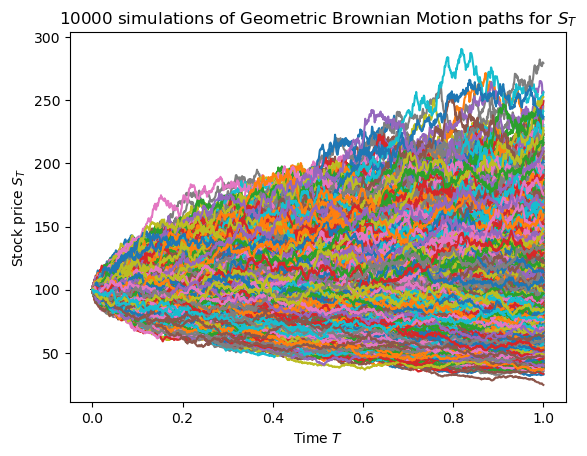

In [175]:
# simulating with arbitrary parameters 
S0 = 100 # value of underlying asset at t = 0
r = 0 # risk-free rate
sigma = 0.3 # volitility 
T = 1 # timeframe 
n = 10000 # number of simulations 
K = 95 # strike price
disc = 1000

times, St = GBM(S0 = S0, time = T, vol = sigma, rfr = r, steps = disc, samples = n, vis = False)
plt.plot(times, St)
plt.xlabel(r'Time $T$')
plt.ylabel(r'Stock price $S_T$')
plt.title(r'{} simulations of Geometric Brownian Motion paths for $S_T$'.format(n))
plt.show()

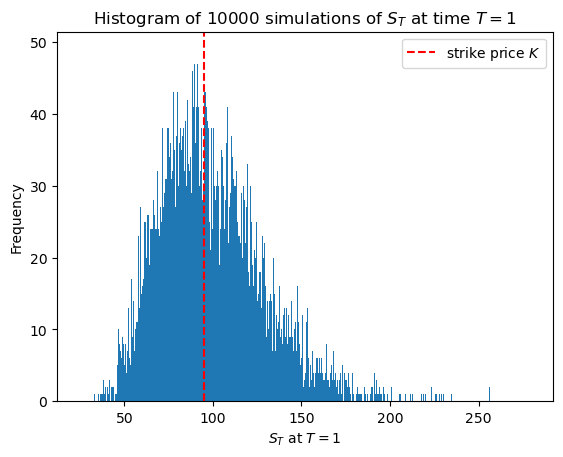

In [176]:
# visualising the distribution of the stock price at time t = T= 1
St1 = St[-1]

plt.hist(St1, bins = 1000)
plt.xlabel(r'$S_T$ at $T =1$')
plt.ylabel("Frequency")
plt.title(r'Histogram of {} simulations of $S_T$ at time $T=1$'.format(n))
plt.axvline(x= K, color = 'red', label = r'strike price $K$', linestyle = 'dashed')
plt.legend()
plt.show()

Now we are going to estimate 
$$ \tilde{{\mathbb{E}}}[\max(S_T - K, 0)] $$
by finding the sample mean of payoff in the simulations 
$$ \tilde{\mathbb{E}}[\max(S_T - K, 0)] \approx\frac{1}{N} \sum\limits_{j }^{} \max[S_j - K, 0] $$
where $N$ is the number of simulations.

In [177]:
# estimating the expected call return 
St1 = St[-1]
St1 = St1 - K 
C0_MC1 = St1[St1 > 0].sum() / St.shape[1] 
C0_MC1

14.100452756872482

In [178]:
# let's compare the above value with the obtained from the closed form of Black-Scholes option pricing formula
# defining the function for Black-Scholes option princing formula 
def BS_option_call(*, maturity, S0, rfr, strike, time = 0, vol):
    import numpy as np 
    from scipy.stats import norm

    if time > strike:
        raise 'Time parameter is more than maturity parameter'
    
    d1 = (np.log(S0 / strike)  + (rfr + vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    d2 = (np.log(S0 / strike)  + (rfr - vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    return S0 * norm.cdf(d1) - np.exp(- rfr * (maturity - time)) * strike * norm.cdf(d2)

In [179]:
C0_BS1 = BS_option_call(maturity = T, S0 = S0, rfr = r, strike = K, vol = sigma)
C0_BS1

14.293649102263295

In [180]:
# computing the standard error of the estimator 
St1[St1 <= 0 ] = 0
SE1 = St1.std(ddof = 1) / np.sqrt(n)
SE1


0.220015118044181

## Result of first simulation

In [181]:
error = (np.abs(C0_MC1 - C0_BS1) / C0_BS1) * 100
print('Monte Carlo simulation option pricing: ', C0_MC1)
print('Analytical Black-Scholes option pricing: ', C0_BS1)  
print('Percentage error: ', error, '%')

Monte Carlo simulation option pricing:  14.100452756872482
Analytical Black-Scholes option pricing:  14.293649102263295
Percentage error:  1.351623675721982 %


## Second simulations
Parameters used are:
1. Initial value of the underlying asset $S_0 = 100$
2. Risk free rate $r = 0$ 
3. Volatility $ \sigma = 0.3$ 
4. Maturity/Expiration date, $ T= 3 $ in day(s) 
5. Strike price, $K = 100$
6. Number of simulations, $n = 10000$  
7. 1000 discretisation steps


In [182]:
S0 = 100 # value of underlying asset at t = 0
r = 0 # risk-free rate
sigma = 0.3 # volitility 
T = 3 # timeframe 
n = 10000 # number of simulations 
K = 100 # strike price
disc = 1000


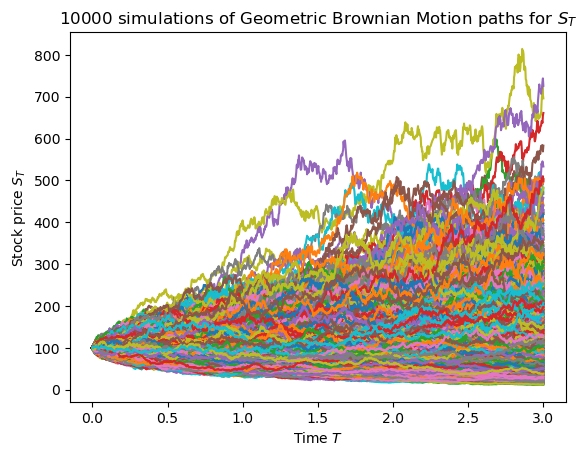

In [183]:
times, St = GBM(S0 = S0, time = T, vol = sigma, rfr = r, steps = disc, samples = n, vis = False)
plt.plot(times, St)
plt.xlabel(r'Time $T$')
plt.ylabel(r'Stock price $S_T$')
plt.title(r'{} simulations of Geometric Brownian Motion paths for $S_T$'.format(n))
plt.show()

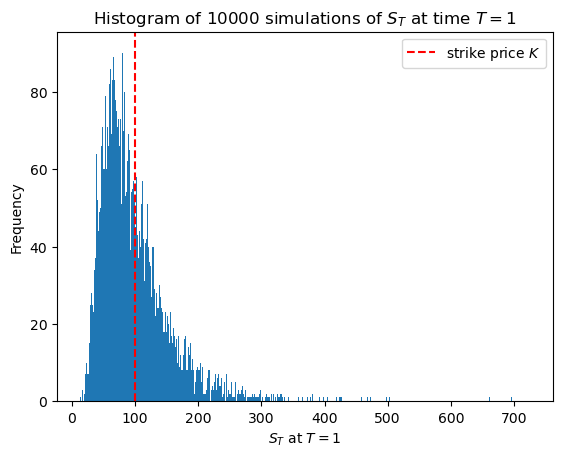

In [184]:
St1 = St[-1]

plt.hist(St1, bins = 1000)
plt.xlabel(r'$S_T$ at $T =1$')
plt.ylabel("Frequency")
plt.title(r'Histogram of {} simulations of $S_T$ at time $T=1$'.format(n))
plt.axvline(x= K, color = 'red', label = r'strike price $K$', linestyle = 'dashed')
plt.legend()
plt.show()

In [185]:
St1 = St[-1]
St1 = St1 - K 
C0_MC2 = np.exp(-r * T) * St1[St1 > 0].sum() / St.shape[1] 
C0_MC2

20.29856477301127

In [186]:
C0_BS2 = BS_option_call(maturity = T, S0 = S0, rfr = r, strike = K, vol = sigma)
C0_BS2

20.498782803576184

In [187]:
error = (np.abs(C0_MC2 - C0_BS2) / C0_BS2) * 100
print('Monte Carlo simulation option pricing: ', C0_MC2)
print('Analytical Black-Scholes option pricing: ', C0_BS2)  
print('Percentage error: ', error, '%')

Monte Carlo simulation option pricing:  20.29856477301127
Analytical Black-Scholes option pricing:  20.498782803576184
Percentage error:  0.9767313136757673 %


## Speeding Up wth antithetic variance reduction technique. 
We can write the $j$-th Brownian path of the stock price $S_t$ as 
   $$ S_t^j = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W}_t^j \right) $$
the use the antithetic variance reduction method, we will compute two Brownian paths for the stock price that are perfectly negatively correlated. The two paths are given by 
   $$ S_t^j = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W}_t^j \right) $$
   $$\overline{S_t^j } = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t - \sigma \tilde{W}_t^j \right) $$
   then the analogous approximation as stated earlier will be 
   $$ \tilde{\mathbb{E}}[\max(S_T - K , 0)] \approx \frac{1}{N} \sum\limits_{j =1}^{N } \frac{\max(S_T^j - K ,0 ) + \max(\overline{S_T^j } - K , 0)}{2}  $$
   We will compare the performances between the antithetic variance reduction method and the standard Monte Carlo method in valueting option. 

In [188]:
S0 = 100 # value of underlying asset at t = 0
r = 0 # risk-free rate
sigma = 0.3 # volitility 
T = 1 # timeframe 
n = 5000 # number of simulations 
K = 95 # strike price
disc = 1000


In [189]:
# a slight modification to our original GBM functions found in the other project mentioned
# this GBM_AVR produces two paths that are perfectly negatively correlated
def GBM_AVR(vis = True, *, S0, time, steps, samples, vol, rfr):
    import numpy as np 
    import matplotlib.pyplot as plt
    times, Bt = BM(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    nSt = S0 * np.exp((rfr - vol**2 /2)* times_d - vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St, nSt
    else: 
        return times, St, nSt


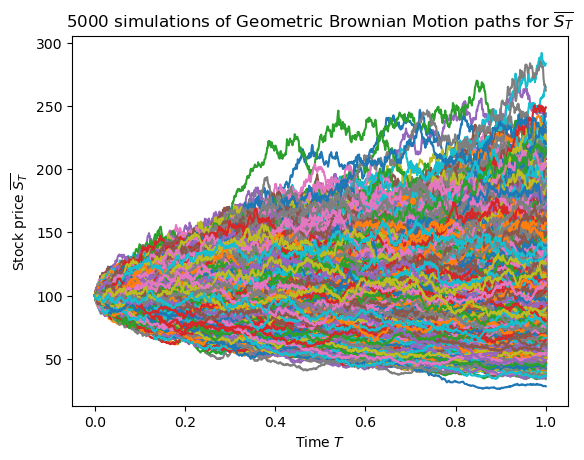

In [190]:
times, St, nSt = GBM_AVR(S0 = S0, time = T, vol = sigma, rfr = r, steps = disc, samples = n, vis = False)
plt.plot(times, nSt)
plt.xlabel('Time $T$')
plt.ylabel('Stock price $\\overline{S_T}$')
plt.title('{0} simulations of Geometric Brownian Motion paths for $\\overline{{S_T}}$'.format(n))
plt.show()

In [191]:
# computing our MC with AVR estimator
St1 = St[-1] - K
St2 = nSt[-1] - K
C0_MC_AVR = np.exp(-r * T) * (St1[St1 > 0].sum() + St2[St2 > 0].sum())  / (St.shape[1] * 2)
C0_MC_AVR

14.345341086884956

In [192]:
error = (np.abs(C0_MC_AVR - C0_BS1) / C0_BS1) * 100
print('MC simulation with AVR option pricing: ', C0_MC_AVR)
print('Analytical Black-Scholes option pricing: ', C0_BS1)  
print('Percentage error: ', error, '%')

MC simulation with AVR option pricing:  14.345341086884956
Analytical Black-Scholes option pricing:  14.293649102263295
Percentage error:  0.36164302237890766 %


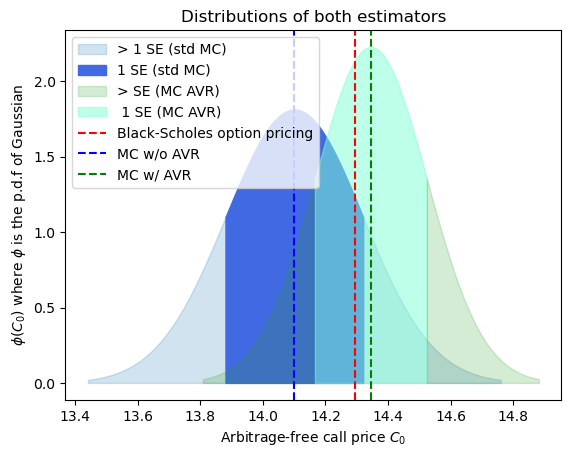

In [193]:
St1[St1 <= 0] = 0
St2[St2 <= 0] = 0 
S = 0.5 * (St1 + St2)
SE2 = S.std(ddof= 1) / np.sqrt(n)

x1 = np.linspace(C0_MC1 - 3 * SE1, C0_MC1 - 1 * SE1, 100)
X1 = np.linspace(C0_MC_AVR - 3 * SE2, C0_MC_AVR - 1 * SE2, 100)
x2 = np.linspace(C0_MC1 - 1 * SE1, C0_MC1 + 1 * SE1, 100)
X2 = np.linspace(C0_MC_AVR - 1 * SE2, C0_MC_AVR + 1 * SE2, 100)
x3 = np.linspace(C0_MC1 + 1 * SE1, C0_MC1 + 3 * SE1, 100)
X3 = np.linspace(C0_MC_AVR + 1 * SE2, C0_MC_AVR + 3 * SE2, 100)

y1 = ss.norm.pdf(x1, C0_MC1, SE1)
Y1 = ss.norm.pdf(X1, C0_MC_AVR, SE2)
y2 = ss.norm.pdf(x2, C0_MC1, SE1)
Y2 = ss.norm.pdf(X2, C0_MC_AVR, SE2)
y3 = ss.norm.pdf(x3, C0_MC1, SE1)
Y3 = ss.norm.pdf(X3, C0_MC_AVR, SE2) 

plt.fill_between(x1, y1, color = 'tab:blue', label = '> 1 SE (std MC)', alpha = 0.2)
plt.fill_between(x2, y2, color = 'royalblue', alpha = 1, label = '1 SE (std MC) ')
plt.fill_between(x3, y3, color = 'tab:blue', alpha = 0.2)

plt.fill_between(X1, Y1, color = 'tab:green', label = '> SE (MC AVR)', alpha = 0.2)
plt.fill_between(X2, Y2, color = 'aquamarine', label = ' 1 SE (MC AVR)', alpha = 0.5)
plt.fill_between(X3, Y3, color = 'tab:green', alpha = 0.2)

plt.axvline(x = C0_BS1, color = 'r', linestyle = 'dashed', label = 'Black-Scholes option pricing')
plt.axvline(x = C0_MC1, color = 'blue', linestyle = 'dashed', label = 'MC w/o AVR')
plt.axvline(x = C0_MC_AVR, color = 'green', linestyle = 'dashed', label = 'MC w/ AVR')

plt.xlabel('Arbitrage-free call price $C_0$')
plt.ylabel('$\phi(C_0)$ where $\phi$ is the p.d.f of Gaussian')
plt.title('Distributions of both estimators')
plt.legend()
plt.show()